In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
# Install neurogym to use cognitive tasks
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .

Cloning into 'neurogym'...
remote: Enumerating objects: 13187, done.
remote: Counting objects: 100% (1488/1488), done.
remote: Compressing objects: 100% (373/373), done.
remote: Total 13187 (delta 1166), reused 1220 (delta 1100), pack-reused 11699 (from 1)
Receiving objects: 100% (13187/13187), 10.67 MiB | 23.31 MiB/s, done.
Resolving deltas: 100% (9972/9972), done.
/content/neurogym
Obtaining file:///content/neurogym
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.4/696.4 kB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.24.1-py3-none-any.whl size=793129 sha256=9c7bdfeef484763be086062071b41703097a796a23610c2b9da67d0638f302bf
  Stored in directory: /root/.cache/pip/wheels/c4/fb/19/388995b88cb551717a8dff40c889172cd12fadf994216a0a22
Successfully built gym
  Attempting uninstall: gym
    Found existi

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time
import neurogym as ngym


from torch.nn import init
from torch.nn import functional as F
import math
from matplotlib.lines import Line2D

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


# Coursework Q2 File

## Part A
### What?
For this part we need to train two AI models, a standard RNN and a a brain inspired-variation

The standard - vanilla RNN, leaky RNN, light GRU, GRU, LSTM

These can be found in lab sheets:
vanilla RNN - \\
leaky RNN - 1,3,4\\
light RNN - \\
light GRU - \\
GRU - \\
LSTM - 3\\

### How to write
We need to explain this with equations and scematic diagrams, comparing the differences between the two.


Using leakyRNN code from lab sheet 3


#### Load Perceptual Decision Making data

### Variable center

In [ ]:
def general_train_model(net, dataset,lr = 0.01, n_steps=2000, verbose=False):
    """Simple helper function to train the model.

    Args:
        net: a pytorch nn.Module module
        dataset: a dataset object that when called produce a (input, target output) pair

    Returns:
        net: network object after training
    """
    env = dataset.env
    env.reset(no_step=True)

    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    loss_values = []
    acc_values = []
    running_loss = 0
    running_acc = 0
    start_time = time.time()
    print_step = 100
    # Loop over training batches
    print('Training network...')
    for i in range(n_steps):
        # Generate input and target, convert to pytorch tensor
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # boiler plate pytorch training:
        optimizer.zero_grad()   # zero the gradient buffers
        output,_ = net(inputs)
        # Reshape to (SeqLen x Batch, OutputSize)
        output = output.view(-1, output_size)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()    # Does the update

        # Compute the running loss and accuracy every 100 steps
        running_loss += loss.item()
        running_acc += (output.argmax(dim=1) == labels).float().mean().item()
        if i % print_step == print_step-1:
            average_loss = running_loss/ print_step
            average_acc = running_acc / print_step
            if average_loss > 1:
                print('Loss spike at step {}, value {:0.4f}'.format(i+1,average_loss))

            if verbose:
                print('Step {}, Loss {:0.4f}, Acc {:0.4f}, Time {:0.1f}s'.format(
                    i+1, average_loss, average_acc , time.time() - start_time))
            loss_values.append(average_loss)
            acc_values.append(average_acc)
            running_loss = 0
            running_acc = 0
    print('Final Step {}, Loss {:0.4f}, Acc {:0.4f}, Time {:0.1f}s'.format(
                    i+1, average_loss, average_acc , time.time() - start_time))
    return net, loss_values, acc_values

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def sparse_train_model(net, dataset,lr = 0.01, n_steps=2000, verbose=False):
    """Simple helper function to train the model.

    Args:
        net: a pytorch nn.Module module
        dataset: a dataset object that when called produce a (input, target output) pair

    Returns:
        net: network object after training
    """
    env = dataset.env
    env.reset(no_step=True)

    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    loss_values = []
    acc_values = []
    running_loss = 0
    running_acc = 0
    start_time = time.time()
    print_step = 100
    # Loop over training batches
    print('Training network...')
    for i in range(n_steps):
        # Generate input and target, convert to pytorch tensor
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # boiler plate pytorch training:
        optimizer.zero_grad()   # zero the gradient buffers
        output,_ = net(inputs)
        # Reshape to (SeqLen x Batch, OutputSize)
        output = output.view(-1, output_size)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()    # Does the update

        # Reapply sparsity masks
        with torch.no_grad():
            net.rnn.input2h.weight *= net.rnn.input2h_mask
            net.rnn.h2h.weight *= net.rnn.h2h_mask

        # Compute the running loss and accuracy every 100 steps
        running_loss += loss.item()
        running_acc += (output.argmax(dim=1) == labels).float().mean().item()
        if i % print_step == print_step-1:
            average_loss = running_loss/ print_step
            average_acc = running_acc / print_step
            if average_loss > 1:
                print('Loss spike at step {}, value {:0.4f}'.format(i+1,average_loss))

            if verbose:
                print('Step {}, Loss {:0.4f}, Acc {:0.4f}, Time {:0.1f}s'.format(
                    i+1, average_loss, average_acc , time.time() - start_time))
            loss_values.append(average_loss)
            acc_values.append(average_acc)
            running_loss = 0
            running_acc = 0
    print('Final Step {}, Loss {:0.4f}, Acc {:0.4f}, Time {:0.1f}s'.format(
                    i+1, average_loss, average_acc , time.time() - start_time))
    return net, loss_values, acc_values

In [ ]:
def neurom_train_model(net, dataset, lr=0.01, lr_increase_factor=1.1, lr_decrease_factor=0.9, patience=5, n_steps=2000, verbose=False):
    """
    Train a PyTorch neural network model with neuromodulation-style learning rate updates.

    Args:
        net: a PyTorch nn.Module model.
        dataset: a dataset object that generates (input, target output) pairs.
        lr: initial learning rate.
        lr_increase_factor: factor by which to increase the learning rate on success.
        lr_decrease_factor: factor by which to decrease the learning rate on stagnation.
        patience: number of steps to wait before decreasing learning rate on stagnation.
        n_steps: number of training steps.
        verbose: whether to print detailed logs during training.

    Returns:
        net: trained network object.
        loss_values: list of average losses over the training process.
        acc_values: list of average accuracies over the training process.
    """
    import time

    env = dataset.env
    env.reset(no_step=True)

    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    loss_values = []
    acc_values = []
    running_loss = 0
    running_acc = 0
    start_time = time.time()
    print_step = 100

    # Neuromodulation variables
    best_loss = float('inf')  # Initialize the best loss to a very high value
    steps_without_improvement = 0

    print('Training network...')
    for i in range(n_steps):
        # Generate input and target, convert to PyTorch tensors
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # Standard PyTorch training steps
        optimizer.zero_grad()  # Zero the gradient buffers
        output, _ = net(inputs)
        # Reshape to (SeqLen x Batch, OutputSize)
        output = output.view(-1, output_size)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()  # Update the weights

        # Compute the running loss and accuracy every 100 steps
        running_loss += loss.item()
        running_acc += (output.argmax(dim=1) == labels).float().mean().item()

        if i % print_step == print_step - 1:
            average_loss = running_loss / print_step
            average_acc = running_acc / print_step

            # Neuromodulation-style learning rate update based on loss
            if average_loss < best_loss:
                # Success: Learning rate can be increased
                best_loss = average_loss
                steps_without_improvement = 0
                # Increase learning rate
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= lr_increase_factor
                if verbose:
                    print(f"Increasing learning rate to {optimizer.param_groups[0]['lr']:.5f}")
            else:
                # Failure or stagnation: Learning rate can be decreased
                steps_without_improvement += 1
                if steps_without_improvement >= patience:
                    # Decrease learning rate after patience threshold is reached
                    for param_group in optimizer.param_groups:
                        param_group['lr'] *= lr_decrease_factor
                    if verbose:
                        print(f"Decreasing learning rate to {optimizer.param_groups[0]['lr']:.5f}")
                    steps_without_improvement = 0  # Reset the patience counter

            # Print progress if verbose
            if verbose:
                print('Step {}, Loss {:0.4f}, Acc {:0.4f}, Time {:0.1f}s'.format(
                    i + 1, average_loss, average_acc, time.time() - start_time))

            # Save metrics
            loss_values.append(average_loss)
            acc_values.append(average_acc)
            running_loss = 0
            running_acc = 0

    # Final statistics
    print('Final Step {}, Loss {:0.4f}, Acc {:0.4f}, Time {:0.1f}s'.format(
        i + 1, average_loss, average_acc, time.time() - start_time))

    return net, loss_values, acc_values


In [ ]:
# from PlainLeaky import Plain_RNNNet
# from EI_model import EI_Net
# from PlainNoisyLeaky import Plain_Noisy_RNNNet

Plain leaky

In [ ]:
class LeakyRNN(nn.Module):
    """Leaky RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms.
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.

        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)

        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))

        #implement how much the previous hidden layer activity should be maintained in the new activity
        h_new = hidden * (1-self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""

        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class Plain_RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Leaky RNN
        self.input_size = input_size
        self.rnn = LeakyRNN(input_size, hidden_size, **kwargs)

        # Add a Linear output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

sparse leaky

In [ ]:
class SparseLeakyRNN(nn.Module):
    """Leaky RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms.
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

        # Create sparsity masks (for 50% sparsity)
        self.input2h_mask = (torch.rand_like(self.input2h.weight) > 0.5).float()
        self.h2h_mask = (torch.rand_like(self.h2h.weight) > 0.5).float()

        # Apply initial sparsity
        self.apply_sparsity()

    def apply_sparsity(self):
        """Apply sparsity to weights using the precomputed masks."""
        with torch.no_grad():
            self.input2h.weight *= self.input2h_mask
            self.h2h.weight *= self.h2h_mask

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.

        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)

        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))

        #implement how much the previous hidden layer activity should be maintained in the new activity
        h_new = hidden * (1-self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""

        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class Sparse_RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # sparse Leaky RNN
        self.input_size = input_size
        self.rnn = SparseLeakyRNN(input_size, hidden_size, **kwargs)

        # Add a Linear output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output



EI rnn

In [ ]:
class EIRecLinear(nn.Module):

    r"""Recurrent E-I Linear transformation.

    This module implements a linear transformation with recurrent E-I dynamics,
    where part of the units are excitatory and the rest are inhibitory.

    Args:
        hidden_size: int, the number of units in the layer.
        e_prop: float between 0 and 1, the proportion of excitatory units.
        bias: bool, if True, adds a learnable bias to the output.
    """

    __constants__ = ['bias', 'hidden_size', 'e_prop']

    def __init__(self, hidden_size, e_prop, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.e_prop = e_prop
        self.e_size = int(e_prop * hidden_size) # Number of excitatory units
        self.i_size = hidden_size - self.e_size # Number of inhibitory units

        # Weight matrix for the recurrent connections
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Create a mask to define the E-I interactions
        # The mask has ones for E to E/I and negative ones for I to E/I, except the diagonal
        mask = np.tile([1]*self.e_size+[-1]*self.i_size, (hidden_size, 1))
        np.fill_diagonal(mask, 0)
        self.mask = torch.tensor(mask, dtype=torch.float32)

        # Optionally add a bias term
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights and biases
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # Scale the weights for the excitatory neurons
        self.weight.data[:, :self.e_size] /= (self.e_size/self.i_size)

        # Initialize biases
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def effective_weight(self):
        # Apply the mask to the absolute values of the weights to get the effective weight
        # This ensures that weights from excitatory neurons are positive,
        # and weights from inhibitory neurons are negative.
        return F.relu(self.weight) * self.mask

    def forward(self, input):
        # Apply the linear transformation using the effective weights and biases
        # The weights used are non-negative due to the absolute value in effective_weight.
        return F.linear(input, self.effective_weight(), self.bias)

class EIRNN(nn.Module):
    """E-I RNN.

    Reference:
        Song, H.F., Yang, G.R. and Wang, X.J., 2016.
        Training excitatory-inhibitory recurrent neural networks
        for cognitive tasks: a simple and flexible framework.
        PLoS computational biology, 12(2).

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
    """

    def __init__(self, input_size, hidden_size, dt=None,
                 e_prop=0.8, sigma_rec=0, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.e_size = int(hidden_size * e_prop)
        self.i_size = hidden_size - self.e_size
        self.num_layers = 1
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha
        self._sigma_rec = np.sqrt(2 * alpha) * sigma_rec

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = EIRecLinear(hidden_size, e_prop=0.8)

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return torch.zeros(batch_size, self.hidden_size).to(input.device)  # Single tensor for hidden state

    def recurrence(self, input, hidden):
        """Recurrence helper with a single hidden tensor."""
        total_input = self.input2h(input) + self.h2h(hidden)
        state = hidden * self.oneminusalpha + total_input * self.alpha
        state += self._sigma_rec * torch.randn_like(state)
        output = torch.relu(state)
        return output

    def forward(self, input, hidden=None):
        """Propagate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        for i in range(input.size(0)):
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)
        output = torch.stack(output, dim=0)
        return output, hidden

class EI_Net(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Excitatory-inhibitory RNN
        self.input_size = input_size
        self.rnn = EIRNN(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(self.rnn.e_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        rnn_e = rnn_activity[:, :, :self.rnn.e_size]
        out = self.fc(rnn_e)
        return out, rnn_activity


In [ ]:
# Environment
task_no = 2

if task_no == 1:
    task = 'PerceptualDecisionMaking-v0' # Task 1
    print(task)
elif task_no == 2:
    task = 'PerceptualDecisionMakingDelayResponse-v0' # Task 2
    print(task)

# if task == 'PerceptualDecisionMaking-v0':
#     timing = {
#         'fixation': ('choice', (50, 100, 200, 400)),
#         'stimulus': ('choice', (100, 200, 400, 800)),
#     }
#     kwargs = {'dt': 20, 'timing': timing}
# elif task == 'HierarchicalReasoning-v0':
#     kwargs = {'dt': 20, 'timing': {'stimulus': 1000}} #idk why we're setting stimulus, bc it's not an epoch for this task but won't work otherwise


if task == 'PerceptualDecisionMaking-v0':
    timing = {
        'fixation': ('choice', (50, 100, 200, 400)),
        'stimulus': ('choice', (100, 200, 400, 800)),
    }
    kwargs = {'dt': 20, 'timing': timing}
elif task == 'PerceptualDecisionMakingDelayResponse-v0':
    timing = {
       'fixation': ('constant', 500),
       'stimulus': ('constant', 500),
       'delay': ('constant', 500),  # Add delay period
       'decision': ('constant', 500)
   }
    kwargs = {'dt': 20, 'timing': timing}


seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env

inputs, target = dataset()
inputs = torch.from_numpy(inputs).type(torch.float)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

PerceptualDecisionMakingDelayResponse-v0


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [ ]:
print(env.trial)
print(env.start_ind)
print(env.end_ind)

{'ground_truth': 0, 'coh': 51.2}
{'fixation': 0, 'stimulus': 10, 'delay': 30, 'decision': 30}
{'fixation': 10, 'stimulus': 30, 'delay': 30, 'decision': 35}


In [ ]:
# Instantiate the network and print information
hidden_size = 128
learning_rate = 0.01
train_len = 2000

In [ ]:
# leaky_net = Plain_RNNNet(input_size, hidden_size, output_size,dt=env.dt, sigma_rec=0.15)
# leaky_net,leaky_loss_values, leaky_acc_values = general_train_model(leaky_net, dataset, lr = learning_rate, n_steps = train_len, verbose = False)
# EI_net = EI_Net(input_size, hidden_size, output_size,dt=env.dt, sigma_rec=0.15)
# EI_net,EI_loss_values, EI_acc_values = general_train_model(EI_net, dataset, lr = learning_rate, n_steps = train_len,verbose = False)
# sparse_net = Sparse_RNNNet(input_size, hidden_size, output_size,dt=env.dt, sigma_rec=0.15)
# sparse_net,sparse_loss_values, sparse_acc_values = sparse_train_model(sparse_net, dataset, lr = learning_rate, n_steps = train_len,verbose = False)
neurom_net,neurom_loss_values, neurom_acc_values = neurom_train_model(EI_net, dataset, lr = learning_rate,lr_increase_factor=1.1, lr_decrease_factor=0.9, patience=5, n_steps = 5000, verbose = True)


Training network...
Increasing learning rate to 0.01100
Step 100, Loss 0.0871, Acc 0.9606, Time 7.1s
Increasing learning rate to 0.01210
Step 200, Loss 0.0774, Acc 0.9615, Time 14.0s
Step 300, Loss 0.0879, Acc 0.9576, Time 19.9s
Step 400, Loss 0.0826, Acc 0.9597, Time 27.1s
Step 500, Loss 0.0886, Acc 0.9562, Time 33.0s
Step 600, Loss 0.0835, Acc 0.9599, Time 40.2s
Decreasing learning rate to 0.01089
Step 700, Loss 0.0786, Acc 0.9618, Time 46.2s
Step 800, Loss 0.0794, Acc 0.9626, Time 53.4s
Step 900, Loss 0.0791, Acc 0.9616, Time 59.3s
Step 1000, Loss 0.0829, Acc 0.9576, Time 66.3s
Increasing learning rate to 0.01198
Step 1100, Loss 0.0765, Acc 0.9638, Time 72.1s
Step 1200, Loss 0.0766, Acc 0.9642, Time 79.5s
Step 1300, Loss 0.0841, Acc 0.9589, Time 85.7s
Step 1400, Loss 0.0859, Acc 0.9586, Time 92.7s
Step 1500, Loss 0.0770, Acc 0.9615, Time 98.6s
Decreasing learning rate to 0.01078
Step 1600, Loss 0.0780, Acc 0.9608, Time 105.7s
Step 1700, Loss 0.0795, Acc 0.9608, Time 111.9s
Step 1800

In [ ]:
# leaky_net = Plain_RNNNet(input_size, hidden_size, output_size,dt=env.dt, sigma_rec=0.15)
# leaky_net,leaky_loss_values, leaky_acc_values = general_train_model(leaky_net, dataset, lr = learning_rate, n_steps = train_len, verbose = False)

Training network...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Final Step 2000, Loss 0.0577, Acc 0.9712, Time 103.7s


In [ ]:
# EI_net = EI_Net(input_size, hidden_size, output_size,dt=env.dt, sigma_rec=0.15)
# EI_net,EI_loss_values, EI_acc_values = general_train_model(EI_net, dataset, lr = learning_rate, n_steps = train_len,verbose = False)

Training network...
Final Step 2000, Loss 0.0569, Acc 0.9705, Time 155.1s


In [ ]:
# sparse_net = Sparse_RNNNet(input_size, hidden_size, output_size,dt=env.dt, sigma_rec=0.15)
# sparse_net,sparse_loss_values, sparse_acc_values = sparse_train_model(sparse_net, dataset, lr = learning_rate, n_steps = train_len,verbose = False)

Training network...
Final Step 2000, Loss 0.0564, Acc 0.9718, Time 103.1s


In [ ]:
# neurom_net,neurom_loss_values, neurom_acc_values = neurom_train_model(leaky_net, dataset, lr = learning_rate,lr_increase_factor=1.1, lr_decrease_factor=0.9, patience=5, n_steps = train_len, verbose = True)


Training network...
Increasing learning rate to 0.01100
Step 100, Loss 0.0564, Acc 0.9723, Time 5.6s
Step 200, Loss 0.0573, Acc 0.9715, Time 10.4s
Step 300, Loss 0.0582, Acc 0.9706, Time 15.0s
Increasing learning rate to 0.01210
Step 400, Loss 0.0553, Acc 0.9720, Time 20.9s
Step 500, Loss 0.0565, Acc 0.9723, Time 25.4s
Step 600, Loss 0.0570, Acc 0.9716, Time 30.3s
Increasing learning rate to 0.01331
Step 700, Loss 0.0547, Acc 0.9730, Time 36.1s
Step 800, Loss 0.0553, Acc 0.9725, Time 40.6s
Step 900, Loss 0.0558, Acc 0.9717, Time 46.4s
Increasing learning rate to 0.01464
Step 1000, Loss 0.0543, Acc 0.9727, Time 51.2s
Step 1100, Loss 0.0553, Acc 0.9719, Time 56.0s
Step 1200, Loss 0.0552, Acc 0.9722, Time 62.1s
Step 1300, Loss 0.0579, Acc 0.9712, Time 66.9s
Step 1400, Loss 0.0561, Acc 0.9724, Time 72.1s
Decreasing learning rate to 0.01318
Step 1500, Loss 0.0558, Acc 0.9709, Time 77.6s
Step 1600, Loss 0.0544, Acc 0.9731, Time 82.3s
Step 1700, Loss 0.0552, Acc 0.9720, Time 88.0s
Step 1800, 

In [ ]:
# Reset environment
def test_model(net, dataset):
    env = dataset.env
    env.reset(no_step=True)

    # Initialize variables for logging
    perf = 0
    activity_dict = {}  # recording activity
    trial_infos_plain = {}  # recording trial information

    num_trial = 200
    for i in range(num_trial):
        # Neurogym boiler plate
        # Sample a new trial
        trial_info = env.new_trial()
        # Observation and groud-truth of this trial
        ob, gt = env.ob, env.gt
        # Convert to numpy, add batch dimension to input
        inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)

        # Run the network for one trial
        # inputs (SeqLen, Batch, InputSize)
        # action_pred (SeqLen, Batch, OutputSize)
        action_pred, rnn_activity = leaky_net(inputs) # to-do

        # Compute performance
        # First convert back to numpy
        action_pred = action_pred.detach().numpy()[:, 0, :]
        # Read out final choice at last time step
        choice = np.argmax(action_pred[-1, :])
        # Compare to ground truth
        correct = choice == gt[-1]

        # Record activity, trial information, choice, correctness
        rnn_activity = rnn_activity[:, 0, :].detach().numpy()
        activity_dict[i] = rnn_activity
        trial_infos_plain[i] = trial_info  # trial_info is a dictionary
        trial_infos_plain[i].update({'correct': correct})

    # # Print information for sample trials
    # for i in range(5):
    #     print('Trial ', i, trial_infos_plain[i])

    print('Average performance', np.mean([val['correct'] for val in trial_infos_plain.values()]))

In [ ]:
test_model(leaky_net, dataset)
test_model(EI_net, dataset)
test_model(sparse_net, dataset)
test_model(neurom_net, dataset)

Average performance 0.54
Average performance 0.535
Average performance 0.515
Average performance 0.585


In [ ]:
test_model(neurom_net, dataset)


Average performance 0.85


In [ ]:
# # Extract ground truths and correctness from trial_infos
# ground_truths = [info['ground_truth'] for info in trial_infos_plain.values()]
# correctness = [info['correct'] for info in trial_infos_plain.values()]

# # Plot ground truths against correctness
# plt.figure(figsize=(10, 2))
# for i,val in enumerate(ground_truths):
#     if correctness[i] == 1:
#         plt.plot(i,val, 'o', color='green')
#     else:
#         plt.plot(i,val, 'o', color='red')
# plt.xlabel('Trial')
# plt.ylabel('Value')
# plt.title('Ground Truths vs Correctness')
# plt.show()

#trial infos come from the block before, they've been commented out


In [ ]:
#not actually sure what this is for:
# @title Run the network post-training and record neural activity
def post_training_analysis(net):
  # env = dataset.env suggested but don' think I need
  env.reset(no_step=True)
  env.timing.update({'fixation': ('constant', 500),
                    'stimulus': ('constant', 500)})
  perf = 0
  num_trial = 500
  activity_dict = {}
  trial_infos = {}
  stim_activity = [[], []]  # response for ground-truth 0 and 1
  for i in range(num_trial):
      env.new_trial()
      ob, gt = env.ob, env.gt
      inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
      action_pred, rnn_activity = net(inputs)

      # Compute performance
      action_pred = action_pred.detach().numpy()
      choice = np.argmax(action_pred[-1, 0, :])
      correct = choice == gt[-1]

      # Log trial info
      trial_info = env.trial
      trial_info.update({'correct': correct, 'choice': choice})
      trial_infos[i] = trial_info

      # Log stimulus period activity
      rnn_activity = rnn_activity[:, 0, :].detach().numpy()
      activity_dict[i] = rnn_activity

      # Compute stimulus selectivity for all units
      # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
      rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
      stim_activity[env.trial['ground_truth']].append(rnn_activity)

  print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))

  return activity_dict,trial_infos


In [ ]:
leaky_activity_dict,leaky_trial_infos = post_training_analysis(leaky_net)
# EI_activity_dict,EI_trial_infos = post_training_analysis(EI_net)
# sparse_activity_dict,sparse_trial_infos = post_training_analysis(sparse_net)

Average performance 0.842


#### Plain + noise - not actually sure what this is for Dan have we not already done this in the above fucntion (I made it a function)

In [ ]:
# Reset environment
env = dataset.env
env.reset(no_step=True)

# Initialize variables for logging
perf = 0
activity_dict = {}  # recording activity
trial_infos_noisy = {}  # recording trial information

num_trial = 200
for i in range(num_trial):
    # Neurogym boiler plate
    # Sample a new trial
    trial_info = env.new_trial()
    # Observation and groud-truth of this trial
    ob, gt = env.ob, env.gt
    # Convert to numpy, add batch dimension to input
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)

    # Run the network for one trial
    # inputs (SeqLen, Batch, InputSize)
    # action_pred (SeqLen, Batch, OutputSize)
    action_pred, rnn_activity = Noisy_net(inputs) # to-do

    # Compute performance
    # First convert back to numpy
    action_pred = action_pred.detach().numpy()[:, 0, :]
    # Read out final choice at last time step
    choice = np.argmax(action_pred[-1, :])
    # Compare to ground truth
    correct = choice == gt[-1]

    # Record activity, trial information, choice, correctness
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity
    trial_infos_noisy[i] = trial_info  # trial_info is a dictionary
    trial_infos_noisy[i].update({'correct': correct})


# Print information for sample trials
for i in range(5):
    print('Trial ', i, trial_infos_noisy[i])

print('Average performance', np.mean([val['correct'] for val in trial_infos_noisy.values()]))

NameError: name 'Noisy_net' is not defined

### Comparing learning curves

### Plotting functions
#### Combined plots

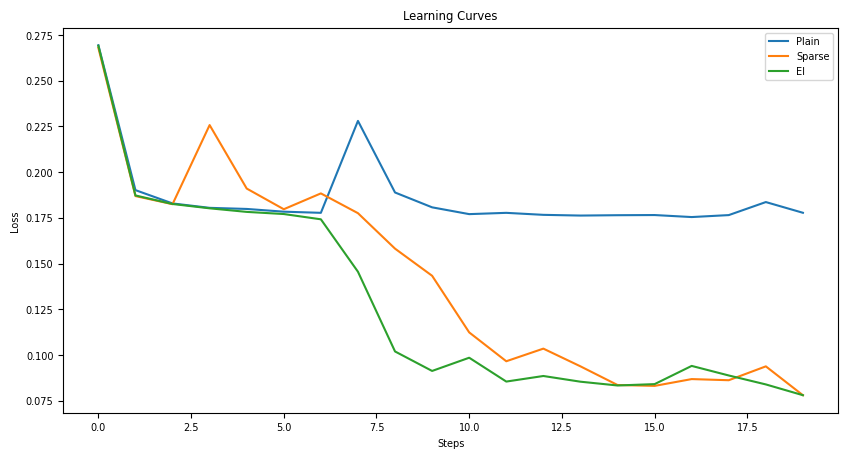

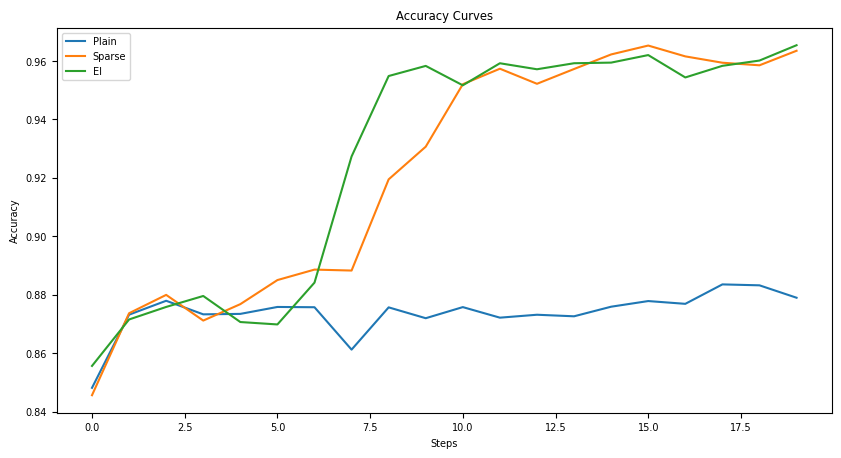

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Learning Curves")
plt.plot(leaky_loss_values, label='Plain')
plt.plot(sparse_loss_values, label='Sparse')
plt.plot(EI_loss_values, label='EI')
# plt.plot(neurom_loss_values, label='Neurom')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
# plt.savefig('graphs/all_loss.svg')

plt.show()

plt.figure(figsize=(10,5))
plt.title("Accuracy Curves")
plt.plot(leaky_acc_values, label='Plain')
plt.plot(sparse_acc_values, label='Sparse')
plt.plot(EI_acc_values, label='EI')
# plt.plot(neurom_acc_values, label='Neurom')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.legend()
# plt.savefig('graphs/all_acc.svg')
plt.show()

#### Seperate Plots

In [ ]:
def loss_accuracy(loss,accuracy, name = ''):
    plt.figure()
    fig,ax = plt.subplots(1,2,figsize=(10,5))

    ax[0].plot(loss)
    ax[0].set_title('Loss')
    ax[0].set_xticklabels(np.arange(len(loss)) * 100)
    ax[0].set_xlabel('Steps')
    # ax[0].set_ylim(0.05,0.1)
    ax[1].plot(accuracy)
    ax[1].set_title('Accuracy')
    ax[1].set_xticklabels(np.arange(len(accuracy)) * 100)
    ax[1].set_xlabel('Steps')

    # plt.savefig(f'graphs/loss_accuracy_{name}.svg')
    plt.show()

<ipython-input-66-8c7101a29dc2>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(np.arange(len(loss)) * 100)
<ipython-input-66-8c7101a29dc2>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(np.arange(len(accuracy)) * 100)


<Figure size 640x480 with 0 Axes>

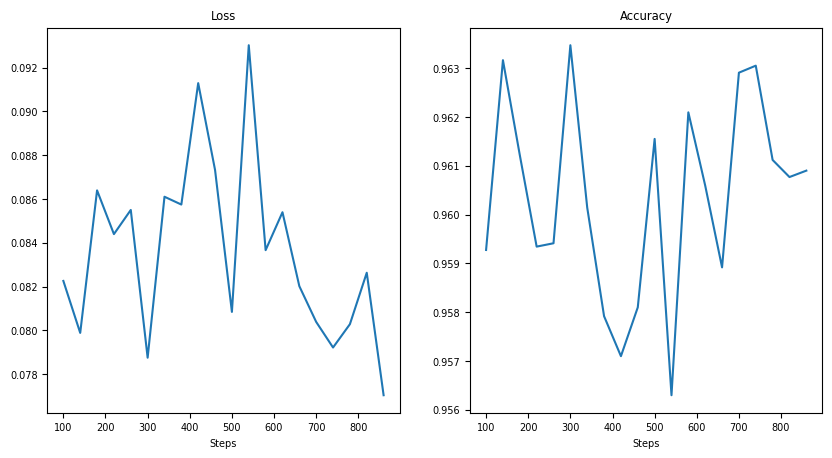

In [ ]:
# loss_accuracy(leaky_loss_values,leaky_acc_values,name='leaky')
loss_accuracy(neurom_loss_values,neurom_acc_values,name='neurom')
# loss_accuracy(EI_loss_values,EI_acc_values,name='EI')
# loss_accuracy(sparse_loss_values,sparse_acc_values,name='sparse')

### Fixed Point finding: doesn't like one of the imports so I might just not bother. Not sure what I would say about them anyway

In [ ]:
# Add the path to the directory containing FixedPointFinderTorch.py
import sys
sys.path.append('../fixed-point-finder')

# Import the FixedPointFinderTorch class
from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
import torch
class FixedPointRNNWrapper(torch.nn.Module):
    def __init__(self, rnn, batch_first=False):
        super(FixedPointRNNWrapper, self).__init__()
        self.rnn = rnn
        self.batch_first = batch_first  # Ensure this matches your RNN's setting

    def forward(self, input, hidden):
        # Squeeze the extra dimension from hidden state
        # Hidden shape transforms from [1, batch_size, hidden_size] to [batch_size, hidden_size]
        hidden = hidden.squeeze(0)

        # EI-RNN expects inputs of shape [seq_len, batch_size, input_size]
        # Since we have seq_len=1, input shape is already correct

        # Forward pass through your EI-RNN
        output, hidden = self.rnn(input, hidden)

        # Unsqueeze hidden to match FixedPointFinder's expectation
        # Hidden shape transforms from [batch_size, hidden_size] to [1, batch_size, hidden_size]
        hidden = hidden.unsqueeze(0)

        # Return None for output as per FixedPointFinder's requirement
        return None, hidden


In [ ]:
def run_fixed_point(net):
    # Instantiate the FixedPointRNNWrapper with the EI-RNN model from Net
    rnn_model_fixed_point = FixedPointRNNWrapper(net.rnn, batch_first=False)

    # Instantiate FixedPointFinder with the wrapped EI-RNN model
    finder = FixedPointFinder(rnn_model_fixed_point)

    # Define initial conditions and inputs for fixed-point analysis
    initial_conditions = torch.randn(10, net.rnn.hidden_size) # 10 random initial hidden states (one for each hidden unit)
    inputs = torch.zeros(10, net.input_size)  # Zero input for each initial condition

    # Convert initial conditions and inputs to NumPy arrays for FixedPointFinder
    init_hidden_np = initial_conditions.cpu().numpy()
    inputs_np = inputs.cpu().numpy()

    # Find fixed points (CHeck FixedPointFinder documentation)
    fixed_points_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)

    # Unpack the returned tuple
    fps = fixed_points_result[0]  # Assuming FixedPoints object is the first element

    # Access fixed points
    fixed_points = fps.xstar  # Now you can access the xstar attribute
    return fixed_points

In [ ]:
leaky_fixed_points = run_fixed_point(leaky_net)
EI_fixed_points = run_fixed_point(EI_net)
sparse_fixed_points = run_fixed_point(sparse_net)

### PCA Analysis

In [ ]:
def run_for_neural(net):
    env.reset(no_step=True)
    if task_no == 1:
      env.timing.update({'fixation': ('constant', 500),
                      'stimulus': ('constant', 500)})
      stim_activity = [[], []]  # response for ground-truth 0 and 1
    elif task_no == 2:
      env.timing.update({'fixation': ('constant', 500),
                       'stimulus': ('constant', 1000),  # Extended stimulus period
                       'delay': ('constant', 500),
                       'decision': ('constant', 500)})
      stim_activity = [[], [], []]  # response for ground-truth=2

    perf = 0
    num_trial = 500
    activity_dict = {}
    trial_infos = {}
    # stim_activity = [[], []]  # response for ground-truth 0 and 1
    for i in range(num_trial):
        env.new_trial()
        ob, gt = env.ob, env.gt
        inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
        action_pred, rnn_activity = net(inputs)

        # Compute performance
        action_pred = action_pred.detach().numpy()
        choice = np.argmax(action_pred[-1, 0, :])
        correct = choice == gt[-1]

        # Log trial info
        trial_info = env.trial
        trial_info.update({'correct': correct, 'choice': choice})
        trial_infos[i] = trial_info

        # Log stimulus period activity
        rnn_activity = rnn_activity[:, 0, :].detach().numpy()
        activity_dict[i] = rnn_activity

        # Compute stimulus selectivity for all units
          # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
        rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
        stim_activity[env.trial['ground_truth']].append(rnn_activity)

        # if task_no == 1:
        #   # Compute stimulus selectivity for all units
        #   # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
        #   rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
        #   stim_activity[env.trial['ground_truth']].append(rnn_activity)

        # elif task_no == 2:

        # # Compute stimulus selectivity for all units
        # # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
        #   rnn_activity = rnn_activity[env.start_ind['delay']: env.end_ind['delay']] #no idea what the best one is for this
        #   stim_activity[env.trial['correct']].append(rnn_activity)

    choices = [val['choice'] for val in trial_infos.values()]
    choice_dist = np.bincount(choices)


    return activity_dict,trial_infos, choice_dist, stim_activity
    # print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))

In [ ]:
env.trial['ground_truth']

In [ ]:
# I don't really understand why we get these again having already calc from post_train stuff. I've put an n infront of all to make them different
nleaky_activity_dict,nleaky_trial_infos, leaky_choice,leaky_stim = run_for_neural(leaky_net)
nEI_activity_dict,nEI_trial_infos, EI_choice, EI_stim= run_for_neural(EI_net)
nsparse_activity_dict,nsparse_trial_infos, sparse_choice, sparse_stim = run_for_neural(sparse_net)
nneurom_activity_dict,nneurom_trial_infos, neurom_choice, neurom_stim = run_for_neural(neurom_net)

In [ ]:
print(leaky_choice)
print(EI_choice)
print(sparse_choice)
print(neurom_choice)

In [ ]:
print(env.trial)
print(env.start_ind)
print(env.end_ind)

In [ ]:
# Import necessary libraries
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

def plot_pca(activity_dict, trial_infos, num_trial, plot_until_time, name = ''):
    num_trial = 500  # Number of trials to analyse

    ### Play with different values here to understand the dynamics
    plot_until_time = 70



    # Concatenate activity data across all trials for PCA
    activity = np.concatenate([activity_dict[i] for i in range(num_trial)], axis=0)
    print('Shape of the neural activity (Time points, Neurons):', activity.shape)

    # Initialize PCA and fit it on the activity data
    pca = PCA(n_components=2) # Using 2 components for visualization
    pca.fit(activity)
    activity_pc = pca.transform(activity)   # Transform to lower dimensions (2D) - hint ".transform" could he helpful
    print('Shape of the projected activity (Time points, PCs):', activity_pc.shape)

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))


    # Plot all trials in ax1 and fewer trials in ax2 for clarity
    for i in range(100):
        # Transform and plot each trial
        activity_pc = pca.transform(activity_dict[i])  # Project each trial's activity

        # Color by ground truth
        trial = trial_infos[i]
        if task_no == 1:
            color = 'red' if trial['ground_truth'] == 0 else 'blue'

        elif task_no == 2:
            # color = 'red' if trial['correct'] == 0 else 'blue'
            if trial['ground_truth'] == 0:
                color = 'red'
            elif trial['ground_truth'] == 1:
                color = 'blue'
            else:
                color = 'green'


        ax1.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)
        if i < 3:  # Fewer trials in ax2 for clear visualization
            ax2.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)

        # Indicate trial start with a different marker
        ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

    # Setting labels and titles for clarity
    ax1.set_title('100 Trials')
    ax2.set_title('3 Trials')
    ax1.set_xlabel('PC 1')
    ax1.set_ylabel('PC 2')

    # plt.savefig(f'graphs/pca_{name}.svg')

    plt.tight_layout()
    plt.show()


Shape of the neural activity (Time points, Neurons): (62500, 128)
Shape of the projected activity (Time points, PCs): (62500, 2)


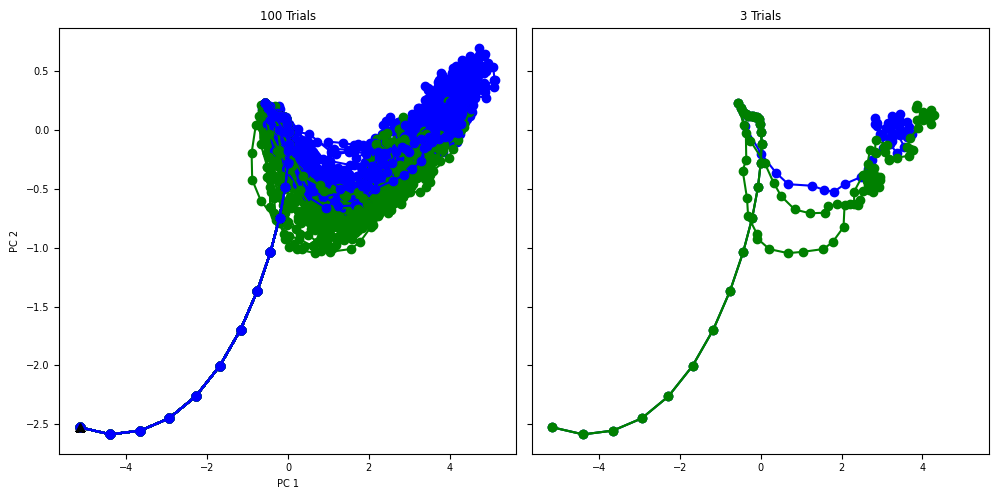

Shape of the neural activity (Time points, Neurons): (62500, 128)
Shape of the projected activity (Time points, PCs): (62500, 2)


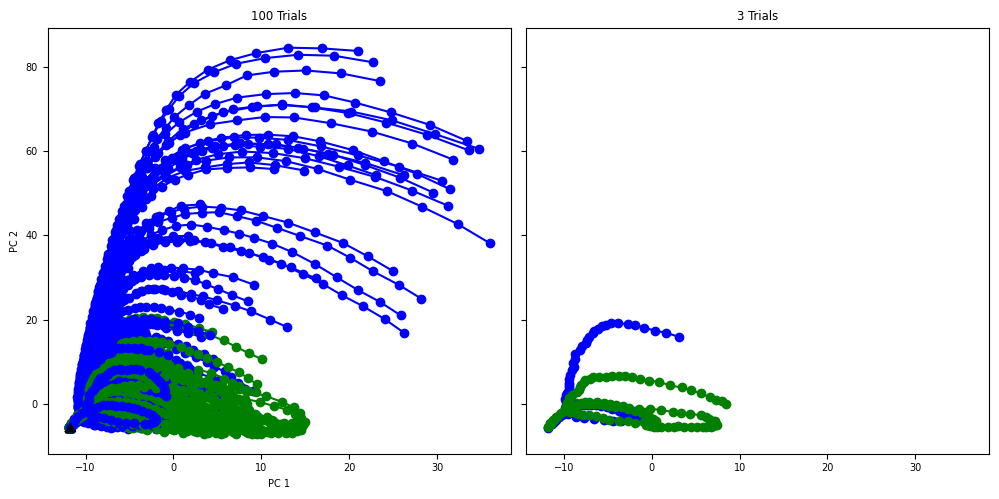

Shape of the neural activity (Time points, Neurons): (62500, 128)
Shape of the projected activity (Time points, PCs): (62500, 2)


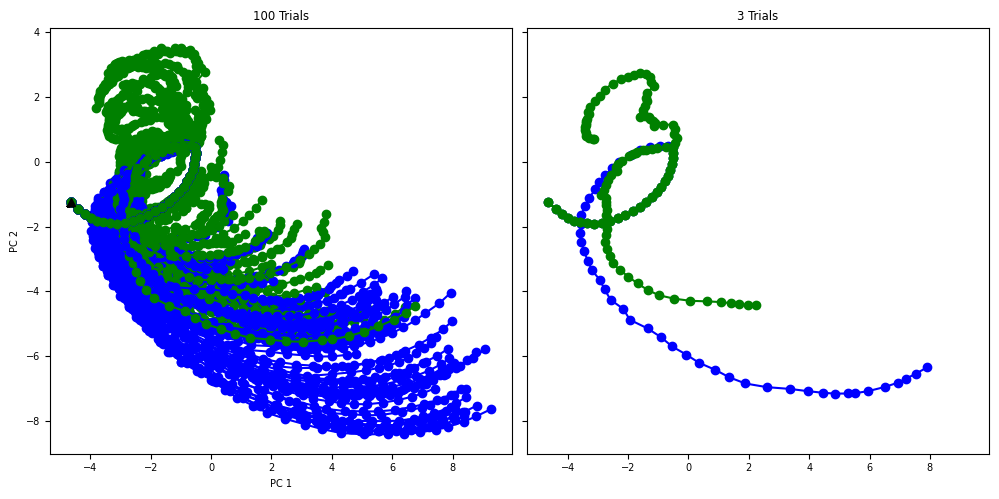

Shape of the neural activity (Time points, Neurons): (62500, 128)
Shape of the projected activity (Time points, PCs): (62500, 2)


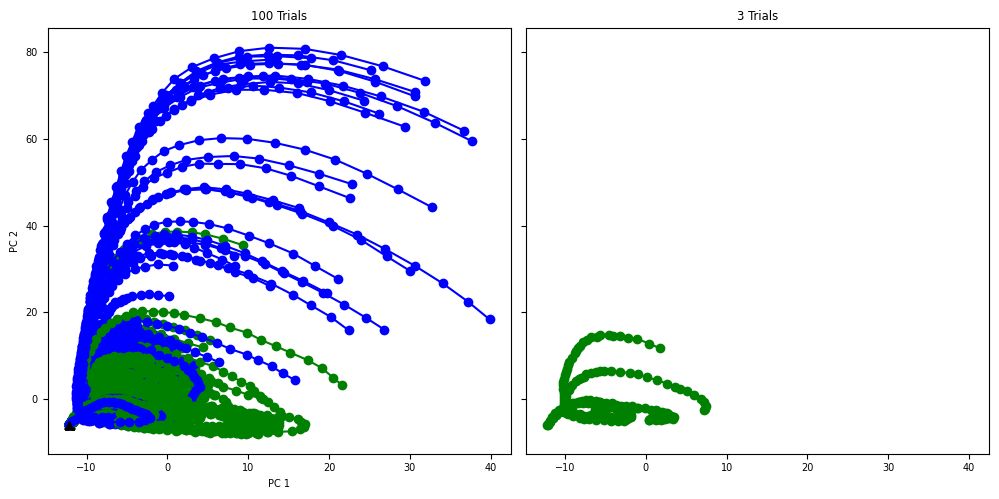

In [ ]:
num_trial = 500
plot_pca(nleaky_activity_dict, nleaky_trial_infos, num_trial, 70, name = 'leaky')
plot_pca(nEI_activity_dict, nEI_trial_infos, num_trial, 70, name = 'EI')
plot_pca(nsparse_activity_dict, nsparse_trial_infos, num_trial, 70, name = 'sparse')
plot_pca(nneurom_activity_dict, nneurom_trial_infos, num_trial, 70, name = 'neurom')

connectivity shit

Text(0, 0.5, 'Activity')

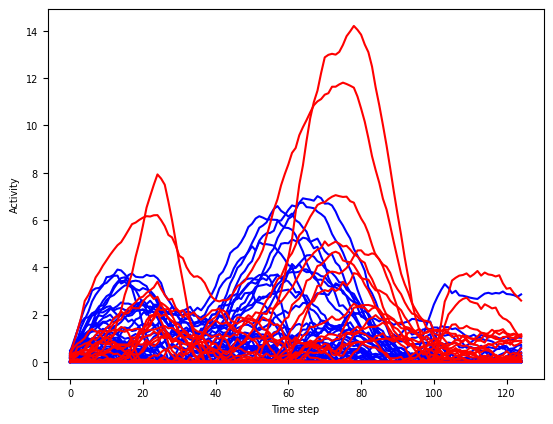

In [ ]:
# @title Plot neural activity from sample trials
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)


import matplotlib.pyplot as plt

#for EI activity plot
e_size = EI_net.rnn.e_size
trial = 2

plt.figure()
_ = plt.plot(nEI_activity_dict[trial][:, :e_size], color='blue', label='Excitatory')
_ = plt.plot(nEI_activity_dict[trial][:, e_size:], color='red', label='Inhibitory')
plt.xlabel('Time step')
plt.ylabel('Activity')


Text(0, 0.5, 'Activity')

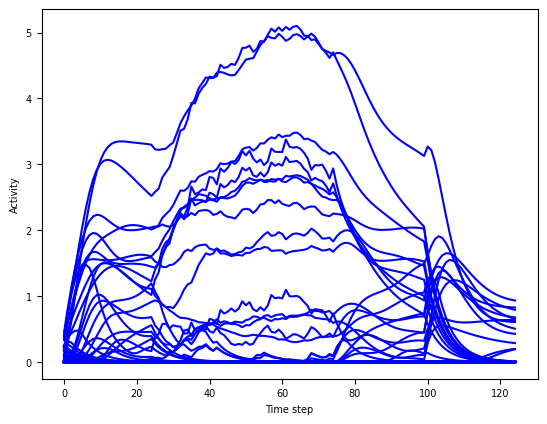

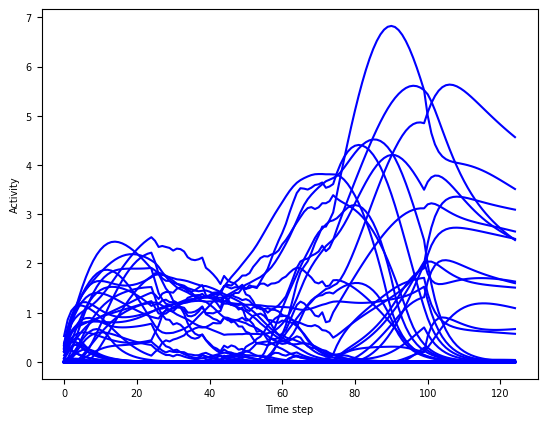

In [ ]:
#I think for not EI e_size is just hidden size
trial = 2

plt.figure()
_ = plt.plot(nleaky_activity_dict[trial][:, :hidden_size], color='blue', label='Excitatory')
_ = plt.plot(nleaky_activity_dict[trial][:, hidden_size:], color='red', label='Inhibitory')
plt.xlabel('Time step')
plt.ylabel('Activity')

plt.figure()
_ = plt.plot(nsparse_activity_dict[trial][:, :hidden_size], color='blue', label='Excitatory')
_ = plt.plot(nsparse_activity_dict[trial][:, hidden_size:], color='red', label='Inhibitory')
plt.xlabel('Time step')
plt.ylabel('Activity')

In [ ]:
#this only works for task1!!!
# @title Compute stimulus selectivity for sorting neurons

#for non EI
# Here for each neuron we compute its stimulus period selectivity
def stim_selectivity(stim_activity):
  mean_activity = []
  std_activity = []
  for ground_truth in [1,2 ]:
      activity = np.concatenate(stim_activity[ground_truth], axis=0)
      mean_activity.append(np.mean(activity, axis=0))
      std_activity.append(np.std(activity, axis=0))

  # Compute d'
  selectivity = (mean_activity[0] - mean_activity[1])
  selectivity /= np.sqrt((std_activity[0]**2+std_activity[1]**2+1e-7)/2)

  # Sort index for selectivity, separately for E and I
  ind_sort = np.argsort(selectivity)

  return selectivity

In [ ]:
for ground_truth in [1,2 ]:
  print(EI_stim[ground_truth])


[array([[0.        , 0.        , 0.        , ..., 0.14451459, 1.4220599 ,
        0.04324135],
       [0.        , 0.        , 0.01818893, ..., 0.23469801, 1.4429891 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.17948145, 1.381092  ,
        0.        ],
       ...,
       [0.        , 0.        , 0.36069065, ..., 0.        , 1.4830288 ,
        0.204611  ],
       [0.        , 0.        , 0.38408366, ..., 0.        , 1.2015593 ,
        0.48872396],
       [0.        , 0.        , 0.39704457, ..., 0.        , 1.1960815 ,
        0.6747723 ]], dtype=float32), array([[0.        , 0.        , 0.0438244 , ..., 0.0551486 , 1.7014198 ,
        0.03347944],
       [0.        , 0.        , 0.        , ..., 0.14092632, 1.8680565 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.4402721 , 2.235762  ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 4.8051286 ,
        1.2811521 ],
       [0.        

In [ ]:
mean_activity = []
std_activity = []
for ground_truth in [1, 2]:
    print(ground_truth)
    activity = np.concatenate(EI_stim[ground_truth], axis=0)
    mean_activity.append(np.mean(activity, axis=0))
    std_activity.append(np.std(activity, axis=0))


# Compute d'
EI_selectivity = (mean_activity[0] - mean_activity[1])
EI_selectivity /= np.sqrt((std_activity[0]**2+std_activity[1]**2+1e-7)/2)

# Sort index for selectivity, separately for E and I
ind_sort = np.concatenate((np.argsort(EI_selectivity[:e_size]),
                           np.argsort(EI_selectivity[e_size:])+e_size))

1
2


In [ ]:
leaky_selectivity = stim_selectivity(leaky_stim)
sparse_selectivity = stim_selectivity(sparse_stim)

In [ ]:
neurom_selectivity = stim_selectivity(neurom_stim)

In [ ]:
def selectivity_plot(selectivity, net):
  plt.figure()
  plt.hist(selectivity)
  plt.xlabel('Selectivity')
  plt.ylabel('Number of neurons')

  # Check if the network has an 'effective_weight' method
  # If not, try to access the weight directly
  try:
    W = net.rnn.h2h.effective_weight().detach().numpy()
  except AttributeError:
    try:
        W = net.rnn.h2h.weight.detach().numpy() # Get weight directly for Linear layer
        print("Using 'weight' attribute instead of 'effective_weight'")
    except AttributeError:
        print("Could not find weight attribute for visualization.")
        return  # Or handle the case differently

  # Sort by selectivity
  W = W[:, ind_sort][ind_sort, :]
  wlim = np.max(np.abs(W))
  plt.figure()
  plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
  plt.colorbar()
  plt.xlabel('From neurons')
  plt.ylabel('To neurons')
  plt.title('Network connectivity')

Using 'weight' attribute instead of 'effective_weight'
Using 'weight' attribute instead of 'effective_weight'


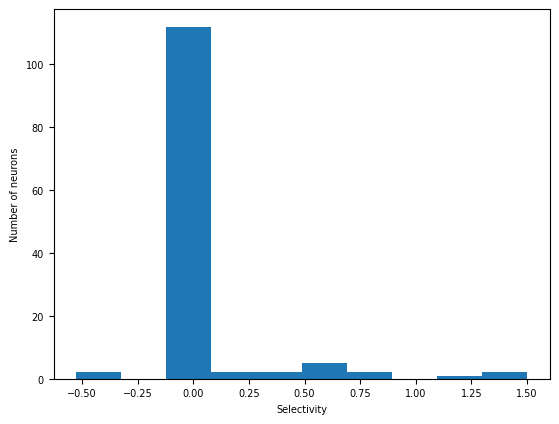

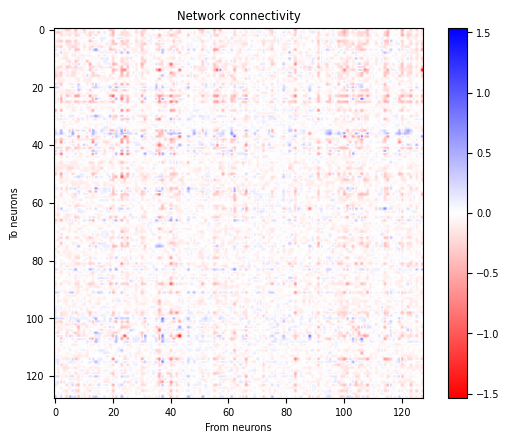

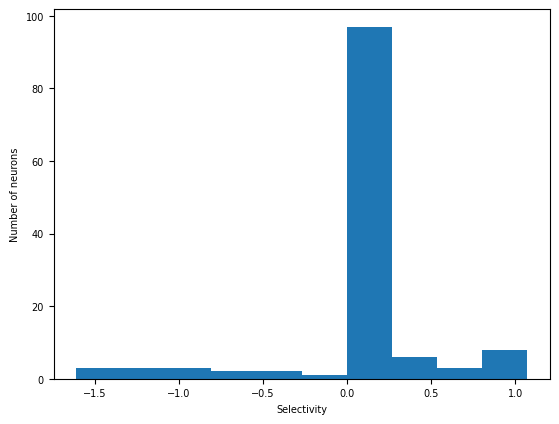

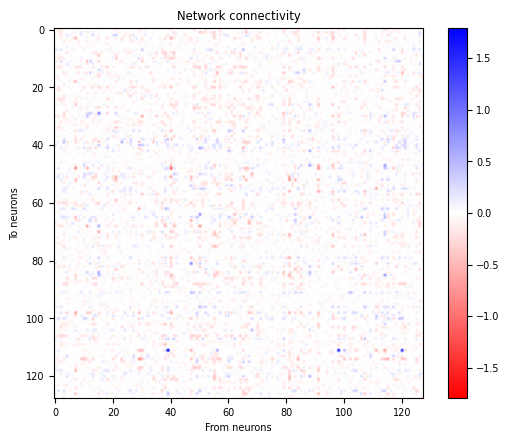

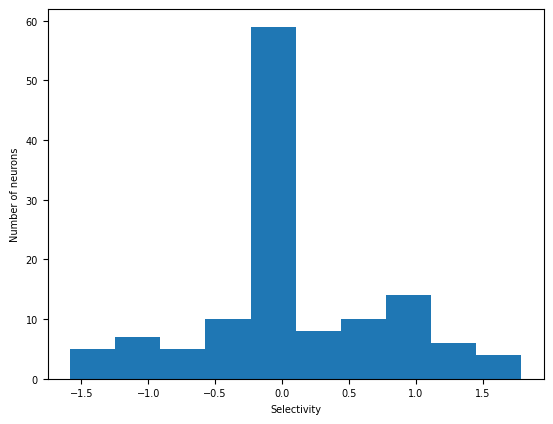

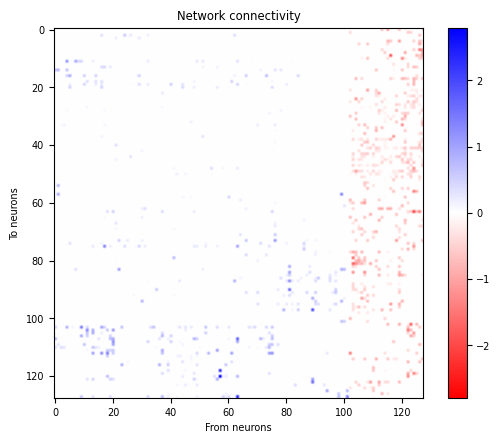

In [ ]:
selectivity_plot(leaky_selectivity, leaky_net)
selectivity_plot(sparse_selectivity,sparse_net)
selectivity_plot(EI_selectivity, EI_net)

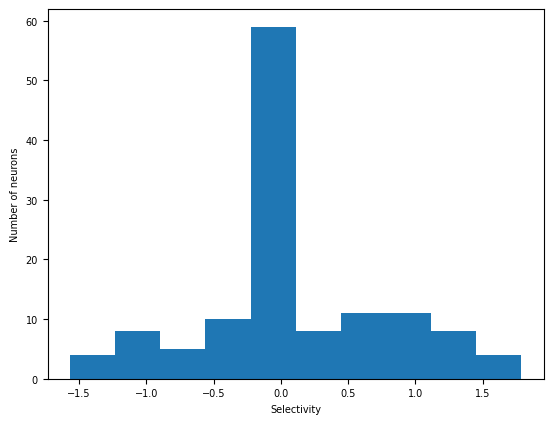

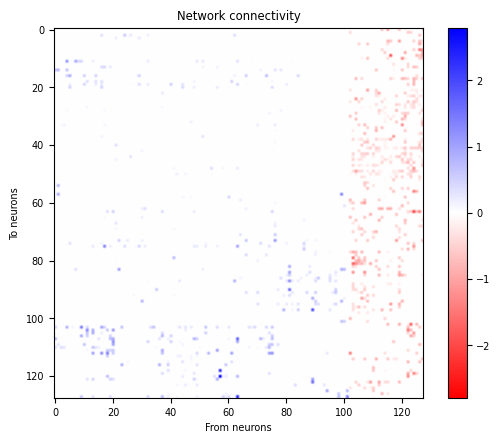

In [ ]:
selectivity_plot(neurom_selectivity, neurom_net)